# TFG - Fórmula 1 - ML

Autor: Manuel Ventura Pacheco

Creación de una NN que nos premita hacer clasificación sobre el dataset que hemos preparado.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Embedding, Dropout, Input, Flatten, BatchNormalization, concatenate, AlphaDropout, StringLookup

from google.colab import drive
import joblib

## Leer data

In [ ]:
read_dir = '/content/drive/MyDrive/Universidad/TFG/data_ready/'
save_dir = '/content/drive/MyDrive/Universidad/TFG/models/'

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv(read_dir+'LEARNING_DF_NORMAL.csv')

## Preparar data

In [ ]:
df = df.loc[df['year'] >= 2000].copy()

# Clipping maximus on grid and position
df['grid'] = df['grid'].clip(upper=20)
df['position'] = df['position'].clip(upper=20)

# Position to one-hot
one_hot = pd.get_dummies(df['position'], prefix='position')
df = df.drop('position',axis = 1)
df = df.join(one_hot)

# Fit columns with scaler
scaler = MinMaxScaler(feature_range=(-1,1))
columns_to_scale = ['grid', 'year', 'round', 'age',	'experience', 'driversPointsBeforeRace', 'constPointsBeforeRace']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Prepare inputs for ML
y = df.iloc[:,15:35].copy()
drivers = df['driverId']
constructors = df['constructorId']
circuits = df['circuitId']
X = df.drop(['driverId', 'constructorId', 'circuitId'], axis=1)
X = X.drop(X.iloc[:,12:32], axis = 1)

# Moddel parameters dependant from input size
N_DRIVERS = len(drivers) + 1
N_CONSTRUCTORS = len(constructors) + 1
N_CIRCUITS = len(circuits) + 1
N_NUMERICS = X.shape[1]

In [ ]:
X

,grid,year,round,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,age,experience,driversPointsBeforeRace,constPointsBeforeRace
0,-1.000000,-0.304348,-1.000000,0,0,0,0,0,-0.566325,-0.910422,-1.000000,-1.000000
1,-0.157895,-0.304348,-0.904762,0,0,0,0,1,-0.564875,-0.908699,-0.953380,-0.961219
2,-0.789474,-0.304348,-0.809524,0,0,1,0,0,-0.561976,-0.905254,-0.934732,-0.933518
3,-0.578947,-0.304348,-0.714286,1,0,0,0,0,-0.557627,-0.900086,-0.934732,-0.922438
4,-0.789474,-0.304348,-0.619048,1,0,0,0,0,-0.554727,-0.896641,-0.906760,-0.905817
...,...,...,...,...,...,...,...,...,...,...,...,...
25975,0.578947,1.000000,-0.809524,1,0,0,0,0,-0.657036,-0.993109,-1.000000,-1.000000
25976,-0.052632,1.000000,-0.714286,0,0,0,0,1,-0.651237,-0.986219,-0.981352,-0.966759
25977,0.894737,1.000000,-0.619048,0,0,0,0,1,-0.649788,-0.984496,-0.981352,-0.961219
25978,0.052632,1.000000,-0.523810,0,0,0,1,0,-0.645439,-0.979328,-0.981352,-0.961219


# Crear modelo

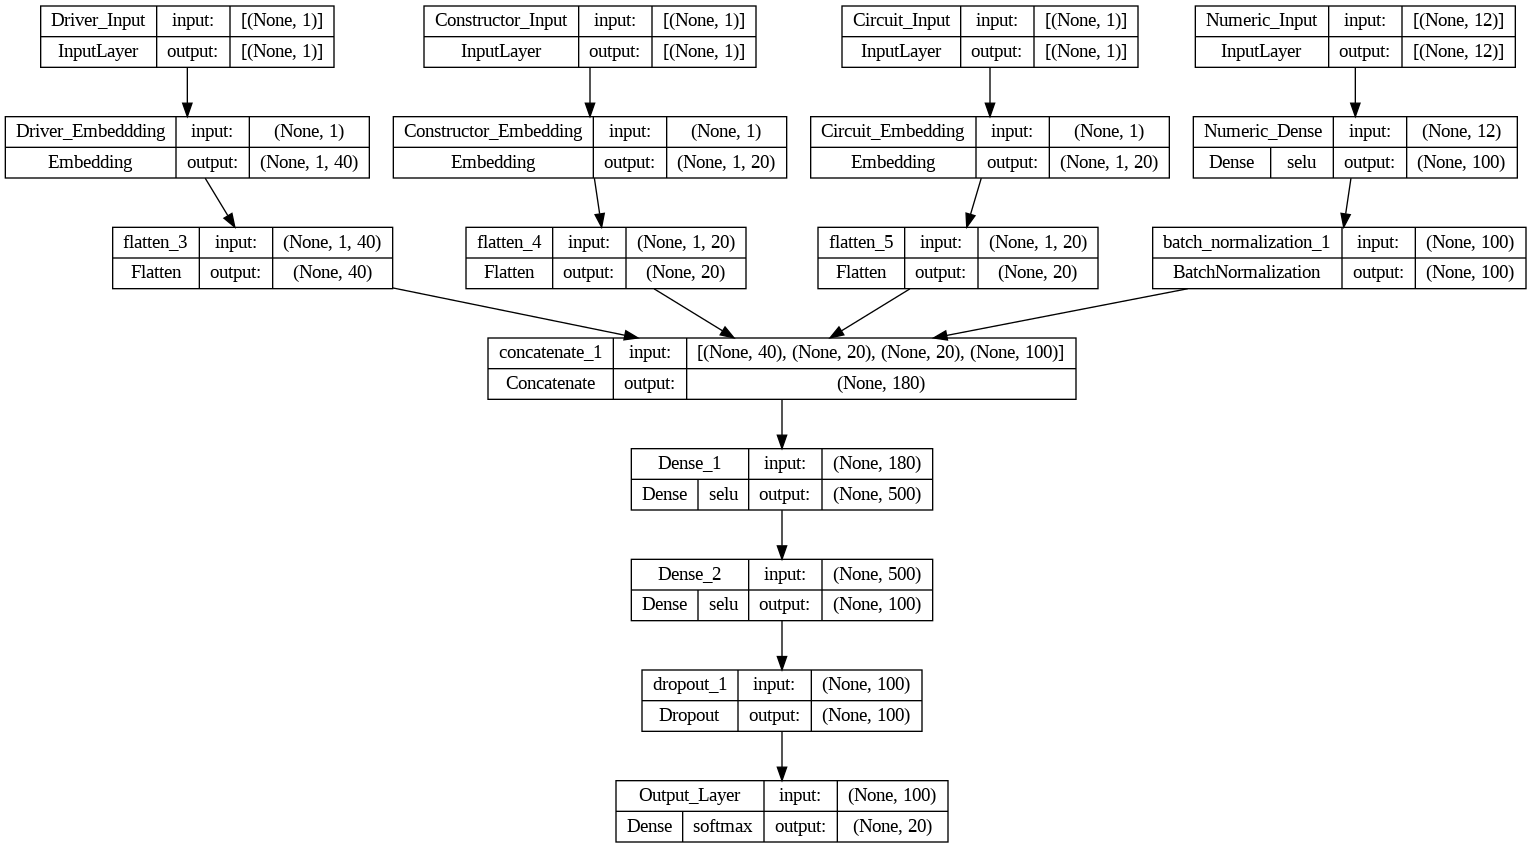

In [ ]:
activation_function = 'selu'
weight_initializer = 'lecun_uniform'





driver_input = Input(shape=(1,), name='Driver_Input')

driver_embedding = Embedding(N_DRIVERS,
                             40,
                             input_length=1,
                             embeddings_initializer=weight_initializer,
                             name='Driver_Embeddding')(driver_input)

driver_flatten = Flatten()(driver_embedding)






constructor_input = Input(shape=(1,), name='Constructor_Input')

constructor_embedding = Embedding(N_CONSTRUCTORS,
                                  20,
                                  input_length=1,
                                  embeddings_initializer=weight_initializer,
                                  name='Constructor_Embedding')(constructor_input)

constructor_flatten = Flatten()(constructor_embedding)






circuit_input = Input(shape=(1,), name='Circuit_Input')

circuit_embedding = Embedding(N_CIRCUITS,
                              20,
                              input_length=1,
                              embeddings_initializer=weight_initializer,
                              name='Circuit_Embedding')(circuit_input)

circuit_flatten = Flatten()(circuit_embedding)









numeric_inputs = Input(shape=(N_NUMERICS,),
                       name='Numeric_Input')

numeric_dense = Dense(100,
                      activation=activation_function,
                      kernel_initializer=weight_initializer,
                      name='Numeric_Dense')(numeric_inputs)

numeric_normalization = BatchNormalization()(numeric_dense)





concat_inputs = concatenate([driver_flatten, constructor_flatten, circuit_flatten, numeric_normalization])








dense_1 = Dense(500,
                activation=activation_function,
                kernel_initializer=weight_initializer,
                name='Dense_1')(concat_inputs)

dense_2 = Dense(100,
                activation=activation_function,
                kernel_initializer=weight_initializer,
                name='Dense_2')(dense_1)

dropout_1 = Dropout(rate=0.3)(dense_2)

out_layer = Dense(20,
                  activation='softmax',
                  kernel_initializer='glorot_uniform',
                  name='Output_Layer')(dropout_1)



model = keras.models.Model(inputs=[driver_input, constructor_input, circuit_input, numeric_inputs],
                           outputs=out_layer)


keras.utils.plot_model(model,
                       show_shapes=True,
                       show_layer_activations=True)

Creamos optimizador, callbackcs, ...

In [ ]:
optim = keras.optimizers.Nadam(learning_rate=0.001)

model.compile(optimizer=optim,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='accuracy',
                                         patience=200)

Entrenar el modelo:

In [ ]:
history = model.fit([drivers, constructors, circuits, X],
                    y,
                    batch_size=64,
                    epochs=3000,
                    shuffle = True,
                    callbacks=[callback])

Epoch 1/3000
146/146 [==============================] - 6s 9ms/step - loss: 0.2214 - accuracy: 0.9528
Epoch 2/3000
146/146 [==============================] - 1s 9ms/step - loss: 0.1943 - accuracy: 0.9462
Epoch 3/3000
146/146 [==============================] - 1s 9ms/step - loss: 0.1620 - accuracy: 0.9528
Epoch 4/3000
146/146 [==============================] - 2s 12ms/step - loss: 0.1527 - accuracy: 0.9528
Epoch 5/3000
146/146 [==============================] - 2s 15ms/step - loss: 0.1628 - accuracy: 0.9486
Epoch 6/3000
146/146 [==============================] - 2s 13ms/step - loss: 0.1577 - accuracy: 0.9515
Epoch 7/3000
146/146 [==============================] - 2s 11ms/step - loss: 0.1387 - accuracy: 0.9543
Epoch 8/3000
146/146 [==============================] - 1s 9ms/step - loss: 0.1486 - accuracy: 0.9513
Epoch 9/3000
146/146 [==============================] - 1s 9ms/step - loss: 0.1452 - accuracy: 0.9546
Epoch 10/3000
146/146 [==============================] - 1s 9ms/step - loss: 0

Guardar modelo y cargarlo de nuevo en caso de necesitarlo.

In [ ]:
model.save(save_dir+'nn_model_categorical_nolookup.h5')
joblib.dump(scaler, save_dir+'minmaxscaler_categorical_nolookup.pkl')

['/content/drive/MyDrive/Universidad/TFG/models/minmaxscaler_categorical_nolookup.pkl']

In [ ]:
model = tf.keras.models.load_model(save_dir+'nn_model_categorical_nolookup.h5')

Ilustrar pérdida durante entrenamiento.

<Axes: >

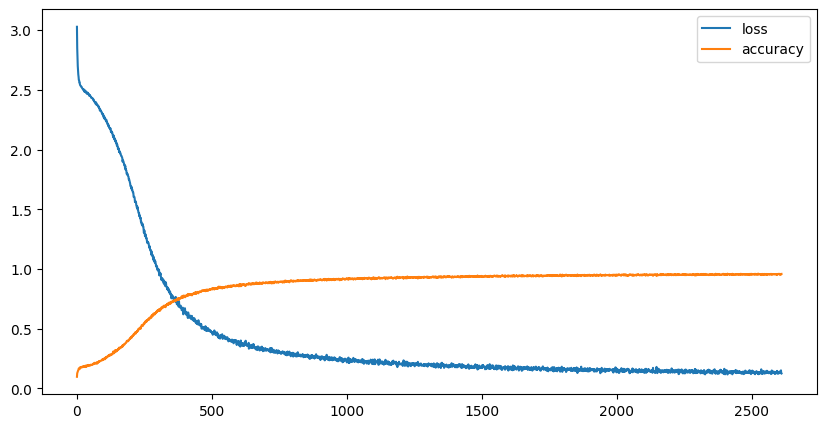

In [ ]:
pd.DataFrame({'loss': history.history['loss'],
              'accuracy': history.history['accuracy']}).plot(figsize=(10,5))